# ***Data Science com Python***
## Modelagem e Avaliação de Resutados - Regressão
### Camila Teixeira

Professor: Lucas Roberto Correa

Estudo de caso: Base de dados de pessoas que um banco entrou em contato para oferecer um investimento. Nessa base consta quem já aceitou e quem não aceitou fazer o investimento. O objetivo deste modelo é saber qual a idade dos clientes mais propensos a aceitar a proposta.

## Import dos pacotes

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV

# configs do pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Import do metadados

In [2]:
metadados = pd.read_excel('metadata.xlsx')

In [3]:
metadados

,Feature,Feature_Type,Description
0,age,numeric,age of a person
1,job,"Categorical,nominal","type of job ('admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')"
2,marital,"categorical,nominal","marital status ('divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)"
3,education,"categorical,nominal","('basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')"
4,default,"categorical,nominal","has credit in default? ('no','yes','unknown')"
5,housing,"categorical,nominal","has housing loan? ('no','yes','unknown')"
6,loan,"categorical,nominal","has personal loan? ('no','yes','unknown')"
7,contact,"categorical,nominal","contact communication type ('cellular','telephone')"
8,month,"categorical,ordinal","last contact month of year ('jan', 'feb', 'mar', …, 'nov', 'dec')"
9,dayofweek,"categorical,ordinal","last contact day of the week ('mon','tue','wed','thu','fri')"


## Import dos dados

In [4]:
df = pd.read_csv('new_train.csv', sep=',')

In [5]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


## Removendo o Y e adaptando a base para um problema regressor

In [6]:
dados = df.drop(columns=['y'], axis=1).copy()

In [7]:
dados.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent


In [8]:
dados.shape

(32950, 15)

## Feature engineering - criação de nova variável

In [9]:
dados['difficulty'] = -1 # desconhecido
# Localizar dados de 'poutcome' igual a 'success' e dados de 'previous' entre (0,4) para 'difficulty' receber valor 0.
dados.loc[(dados['poutcome'] == 'success') & (dados['previous'].between(0,4)), 'difficulty'] = 0 # facil e medio
dados.loc[(dados['poutcome'] == 'success') & (dados['previous'].between(5,8)), 'difficulty'] = 1 # dificil e muito dificil
dados.loc[(dados['poutcome'] == 'failure'), 'difficulty'] = 2 # impossivel

In [10]:
dados['difficulty'].value_counts()

-1    28416
 2     3429
 0     1088
 1       17
Name: difficulty, dtype: int64

In [11]:
dados.corr()

,age,duration,campaign,pdays,previous,difficulty
age,1.000000,-0.001841,0.003302,-0.032011,0.020670,0.002181
duration,-0.001841,1.000000,-0.075663,-0.047127,0.022538,-0.003248
campaign,0.003302,-0.075663,1.000000,0.053795,-0.079051,-0.078568
pdays,-0.032011,-0.047127,0.053795,1.000000,-0.589601,-0.184078
previous,0.020670,0.022538,-0.079051,-0.589601,1.000000,0.783286
difficulty,0.002181,-0.003248,-0.078568,-0.184078,0.783286,1.000000


In [12]:
dados.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'difficulty'],
      dtype='object')

In [13]:
dados.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
difficulty     0
dtype: int64

In [14]:
dados.dtypes

age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
difficulty      int64
dtype: object

## Seperar a target do df de treinamento/ teste (validação)

In [15]:
explicativas = dados.drop(columns=['age']).copy()

In [16]:
explicativas.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,difficulty
0,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,-1
1,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,2
2,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,-1
3,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,-1
4,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,-1


In [17]:
var_resp = dados['age'].copy()

In [18]:
var_resp.head()

0    49
1    37
2    78
3    36
4    59
Name: age, dtype: int64

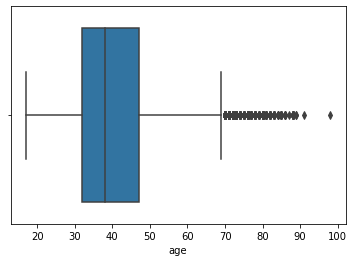

In [23]:
sns.boxplot(x=var_resp);

## Tratamento das variáveis categóricas

In [25]:
explicativas.dtypes

job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
difficulty      int64
dtype: object

In [26]:
expl_cat = explicativas[['job',
                         'marital',
                         'education',
                         'default',
                         'housing',
                         'loan',  
                         'contact',  
                         'month',
                         'day_of_week',
                         'poutcome']]

In [27]:
expl_num = explicativas[['duration',
             'campaign',
             'pdays',
             'previous']]

In [28]:
expl_num.head()

,duration,campaign,pdays,previous
0,227,4,999,0
1,202,2,999,1
2,1148,1,999,0
3,120,2,999,0
4,368,2,999,0


In [29]:
expl_cat_encoding = pd.get_dummies(expl_cat, 
                                   prefix_sep='_',
                                   columns=expl_cat.columns,
                                   drop_first=True)

In [30]:
expl_cat_encoding.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0


In [31]:
explicativas_tratadas = expl_num.merge(expl_cat_encoding, left_index=True, right_index=True)

In [32]:
explicativas_tratadas.head()

,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,227,4,999,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
1,202,2,999,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,1148,1,999,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
3,120,2,999,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,368,2,999,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0


## Feature Selection

### Seleção de variáveis categóricas

In [33]:
dt = DecisionTreeRegressor(random_state=42)

tree_selector = SelectFromModel(dt, max_features=5)
tree_selector.fit(expl_cat_encoding, var_resp)
tree_support = tree_selector.get_support()
tree_feature = expl_cat_encoding.loc[:, tree_support].columns.tolist()
tree_feature

['job_retired', 'marital_single', 'default_unknown', 'housing_yes', 'loan_yes']

### Seleção de variáveis numéricas

In [34]:
rf = RandomForestRegressor(random_state=42)

rfe_selector = RFE(estimator=rf, 
                   n_features_to_select=2)

rfe_selector.fit(expl_num, var_resp)
rfe_support = rfe_selector.get_support()
rfe_feature = expl_num.loc[:, rfe_support].columns.tolist()
rfe_feature

['duration', 'campaign']

## Base a ser considerada na modelagem

In [35]:
expl_num_feature = expl_num[['duration', 'campaign']]

In [36]:
expl_cat.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,nonexistent
1,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,failure
2,retired,married,basic.4y,no,no,no,cellular,jul,mon,nonexistent
3,admin.,married,university.degree,no,yes,no,telephone,may,mon,nonexistent
4,retired,divorced,university.degree,no,no,no,cellular,jun,tue,nonexistent


In [37]:
expl_cat_feature_selection = expl_cat[['job', 'marital','default','housing','loan']].copy()

In [38]:
expl_cat_feature = pd.get_dummies(expl_cat_feature_selection, 
                                   prefix_sep='_',
                                   columns=expl_cat_feature_selection.columns,
                                   drop_first=True)
expl_cat_feature.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
explicativas_modelagem = expl_num_feature.merge(expl_cat_feature, left_index=True, right_index=True)
explicativas_modelagem.head()

,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes
0,227,4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,202,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1148,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,120,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,368,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Quebrar entre train test / treino e teste

In [40]:
x_treino, x_teste, y_treino, y_teste = train_test_split(explicativas_modelagem,
                                                        var_resp,
                                                        test_size=0.3,
                                                        random_state=42)

In [41]:
x_treino.shape

(23065, 22)

In [42]:
x_teste.shape

(9885, 22)

## Treinamento dos modelos

In [43]:
tree = DecisionTreeRegressor(random_state=42)

In [44]:
rf = RandomForestRegressor(random_state=42)

In [45]:
gb = GradientBoostingRegressor(random_state=42)

In [46]:
tree_cross_antes_do_greater_is_better = cross_val_score(estimator= tree, X=x_treino, y= y_treino, cv=3, scoring=make_scorer(mean_absolute_error))

In [47]:
tree_cross = cross_val_score(estimator= tree,
                             X=x_treino,
                             y= y_treino,
                             cv=3,
                             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [48]:
tree_cross_antes_do_greater_is_better

array([9.2936446 , 9.20231313, 9.22613163])

In [49]:
tree_cross

array([-9.2936446 , -9.20231313, -9.22613163])

In [50]:
tree.fit(x_treino, y_treino)

DecisionTreeRegressor(random_state=42)

In [51]:
mean_absolute_error(y_treino, tree.predict(x_treino))

0.8620767396488187

In [52]:
mean_absolute_error(y_teste, tree.predict(x_teste))

9.079376159163715

In [53]:
rf.fit(x_treino, y_treino)

RandomForestRegressor(random_state=42)

In [54]:
gb.fit(x_treino, y_treino)

GradientBoostingRegressor(random_state=42)

In [55]:
mean_absolute_error(y_treino, rf.predict(x_treino))

3.058313480062342

In [56]:
mean_absolute_error(y_teste, rf.predict(x_teste))

7.252896887710165

In [57]:
mean_absolute_error(y_treino, gb.predict(x_treino))

6.57986000531845

In [58]:
mean_absolute_error(y_teste, gb.predict(x_teste))

6.637892323582641

## Tuning de hiperparametros

In [59]:
# Exemplo com Random Forest Regressor

rf_grid_dict = {
    'n_estimators':[50,100,200],
    'bootstrap':[True, False],
    'random_state':[42]
}

In [60]:
rf_grid_dict

{'n_estimators': [50, 100, 200],
 'bootstrap': [True, False],
 'random_state': [42]}

In [61]:
rf_grid = GridSearchCV(rf,
        rf_grid_dict,
        cv=2,
        scoring=make_scorer(mean_absolute_error,greater_is_better=False))

In [62]:
rf_grid

GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'n_estimators': [50, 100, 200], 'random_state': [42]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [63]:
rf_grid.fit(x_treino, y_treino)

GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'n_estimators': [50, 100, 200], 'random_state': [42]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [64]:
rf_grid.best_params_

{'bootstrap': True, 'n_estimators': 200, 'random_state': 42}

In [65]:
rf_grid.best_score_

-7.2717619720221744

In [66]:
mean_absolute_error(y_teste, rf_grid.predict(x_teste))

7.236136896856586

## Tuning com o modelo do GradientBoostingRegressor

In [67]:
gb = GradientBoostingRegressor(random_state=42)

In [68]:
gb_grid_dict = {
    'max_depth':[1,3,8],
    'n_estimators':[10,20],
    'random_state':[42]
}

In [69]:
gb_grid = GridSearchCV(gb,
                       gb_grid_dict,
                       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
                       cv=2,
                       n_jobs=2)

In [70]:
gb_grid.fit(x_treino, y_treino)

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=2,
             param_grid={'max_depth': [1, 3, 8], 'n_estimators': [10, 20],
                         'random_state': [42]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [71]:
gb_grid.best_params_


{'max_depth': 8, 'n_estimators': 20, 'random_state': 42}

In [72]:
gb_grid.best_score_

-6.751334227515821

## Métricas

In [73]:
mean_squared_error(y_treino, gb_grid.predict(x_treino), squared=True)

63.677772810835435

In [74]:
mean_squared_error(y_teste, gb_grid.predict(x_teste), squared=True)

68.68349148754422

## Serializar o modelo

### Fazendo a escrita dos objetos treinados no hard disk

In [75]:
import pickle
import joblib

In [76]:
with open("gb_pickle.pkl", "wb") as modelo:
  pickle.dump(gb_grid, modelo)

In [77]:
joblib.dump(gb_grid, 'gb_joblib.pkl')

['gb_joblib.pkl']

## Leitura dos modelos serializados

In [78]:
modelo_no_pickle = pickle.load(open("gb_pickle.pkl", 'rb'))

In [79]:
modelo_no_pickle

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=2,
             param_grid={'max_depth': [1, 3, 8], 'n_estimators': [10, 20],
                         'random_state': [42]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [80]:
gb_grid

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=2,
             param_grid={'max_depth': [1, 3, 8], 'n_estimators': [10, 20],
                         'random_state': [42]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [81]:
modelo_no_joblib = joblib.load("gb_joblib.pkl")

In [82]:
modelo_no_joblib

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=2,
             param_grid={'max_depth': [1, 3, 8], 'n_estimators': [10, 20],
                         'random_state': [42]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

## Prevendo os valores usando o modelo

In [83]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


In [84]:
explicativas_modelagem.head()

,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes
0,227,4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,202,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1148,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,120,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,368,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [85]:
teste_predicao = explicativas_modelagem.iloc[:5,:]

In [86]:
teste_predicao

,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes
0,227,4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,202,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1148,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,120,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,368,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [87]:
resultado_teste = modelo_no_joblib.predict(teste_predicao)
resultado_teste

array([42.45162562, 40.64432024, 62.15552057, 40.08563763, 66.02690592])

In [88]:
teste_predicao_target = df.iloc[:5,0]
teste_predicao_target

0    49
1    37
2    78
3    36
4    59
Name: age, dtype: int64

In [89]:
mean_absolute_error(teste_predicao_target, resultado_teste)

7.429943516749001

## Exercícios:

### Proposta

* Rodar novamente o pipeline de regressão e usar todas variáveis no processo de modelagem

* no passo de tuning usar os seguintes valores: max_depth:[1,50,100]; n_estimators:[50,200,500]; radom_state:[42]

* comparar os resultados

In [ ]:
# Passos s serem seguidos:
# selecionar os dados de origem
# quebrar as categoricas e numericas
# juntar os dados e formar a ABT
# aplicar feature selection
# selecionar os dados para ABT final de modelagem
# estruturar o dicionario para tuning 
# instanciar os obj
# executar o train
# observar os resultados
# serializar o modelo final

In [90]:
df_exercicio = dados.copy()

In [91]:
df_exercicio.dtypes

age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
difficulty      int64
dtype: object

In [92]:
df_exercicio_cat = df_exercicio.drop(columns=['age','duration','campaign','pdays','previous','difficulty'], axis=1)

In [93]:
df_exercicio_cat.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [94]:
df_exercicio_num = df_exercicio.drop(columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome','age'])

In [95]:
df_exercicio_num.columns

Index(['duration', 'campaign', 'pdays', 'previous', 'difficulty'], dtype='object')

In [96]:
df_exercicio_cat_dum = pd.get_dummies(df_exercicio_cat,
                                      prefix_sep='_',
                                      columns=df_exercicio_cat.columns,
                                      drop_first=True)

In [97]:
df_exercicio_cat_dum.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0


In [98]:
df_exercicio_modelagem = df_exercicio_cat_dum.merge(df_exercicio_num, left_index=True, right_index=True)

In [99]:
df_exercicio_modelagem.shape

(32950, 48)

In [100]:
dados.shape

(32950, 16)

In [101]:
df_exercicio_var_resp = df_exercicio['age']

In [102]:
# seleção de variáveis

In [103]:
dt_teste = DecisionTreeRegressor(random_state=42)

dt_selecao = SelectFromModel(dt_teste,
                             max_features=5)
dt_selecao.fit(df_exercicio_cat_dum, df_exercicio_var_resp)
dt_suporte = dt_selecao.get_support()
dt_feature = df_exercicio_cat_dum.loc[:,dt_suporte].columns.tolist()
dt_feature

['job_retired', 'marital_single', 'default_unknown', 'housing_yes', 'loan_yes']

In [104]:
rf_exercicio = RandomForestRegressor(random_state=42)

rf_selecao = RFE(rf_exercicio,
                 n_features_to_select=5,
                 step=1)
rf_selecao.fit(df_exercicio_num, df_exercicio_var_resp)
rf_suporte = rf_selecao.get_support()
rf_feature = df_exercicio_num.loc[:,rf_suporte].columns.tolist()
rf_feature

['duration', 'campaign', 'pdays', 'previous', 'difficulty']

In [105]:
x_treino_exer, x_teste_exer, y_treino_exer, y_teste_exer = train_test_split(df_exercicio_modelagem, 
                                                                       df_exercicio_var_resp,
                                                                       test_size=0.3,
                                                                       random_state=42)

In [106]:
x_treino_exer.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,duration,campaign,pdays,previous,difficulty
24186,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,39,3,999,0,-1
18087,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,90,2,999,0,-1
6950,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,114,3,999,0,-1
8200,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,138,3,999,0,-1
16051,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,252,1,999,0,-1


In [107]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [108]:
exercicio_dict = {
    'max_depth':[1,50,100],
    'n_estimators':[50,200,500],
    'random_state':[42]
}

In [109]:
# modelo

gb_exercicio = GradientBoostingRegressor(random_state=42)

In [110]:
# tuning

gb_exercicio_tuning = GridSearchCV(gb_exercicio,
                                   exercicio_dict,
                                   cv=2,
                                   scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [111]:
gb_exercicio_tuning

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'max_depth': [1, 50, 100],
                         'n_estimators': [50, 200, 500], 'random_state': [42]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [113]:
gb_exercicio_tuning.fit(x_treino_exer, y_treino_exer)

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'max_depth': [1, 50, 100],
                         'n_estimators': [50, 200, 500], 'random_state': [42]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [114]:
gb_exercicio_tuning.best_estimator_

GradientBoostingRegressor(max_depth=1, n_estimators=500, random_state=42)

In [115]:
gb_exercicio_tuning.best_score_

-6.59142518836844

In [116]:
mean_absolute_error(y_treino_exer, gb_exercicio_tuning.predict(x_treino_exer))

6.576545274552671

In [117]:
mean_absolute_error(y_teste_exer, gb_exercicio_tuning.predict(x_teste_exer))

6.5854359857213085

In [118]:
import joblib

In [119]:
joblib.dump(gb_exercicio_tuning, 'gb_exercicio_tuning.pkl')

['gb_exercicio_tuning.pkl']